waypoints  [[19.83719258  5.81541566]
 [20.4022108  40.6896046 ]
 [13.49541554 13.70150132]
 [40.28418539 46.95202786]
 [25.68988638 39.88589244]
 [ 2.10183855 41.45756689]
 [32.29894439  4.36142513]
 [44.99019502 21.06062991]
 [ 6.83121818 49.68320302]
 [25.70030125 44.82598919]
 [23.18276202 20.24363526]
 [49.36966011 40.237839  ]
 [27.6720315  23.04511661]
 [23.77920497 12.88721264]
 [16.67399342 10.65578978]]
inde [ 9  3  4  1 11 12  8 10  7  5 13  2 14  6  0] [[25.70030125 44.82598919]
 [40.28418539 46.95202786]
 [25.68988638 39.88589244]
 [20.4022108  40.6896046 ]
 [49.36966011 40.237839  ]
 [27.6720315  23.04511661]
 [ 6.83121818 49.68320302]
 [23.18276202 20.24363526]
 [44.99019502 21.06062991]
 [ 2.10183855 41.45756689]
 [23.77920497 12.88721264]
 [13.49541554 13.70150132]
 [16.67399342 10.65578978]
 [32.29894439  4.36142513]
 [19.83719258  5.81541566]]
index  9
dis -167.09875084995087 [31.873425136189372, 46.23996494341058, 0] [25.70030125 44.82598919] 6.332991865985706
index

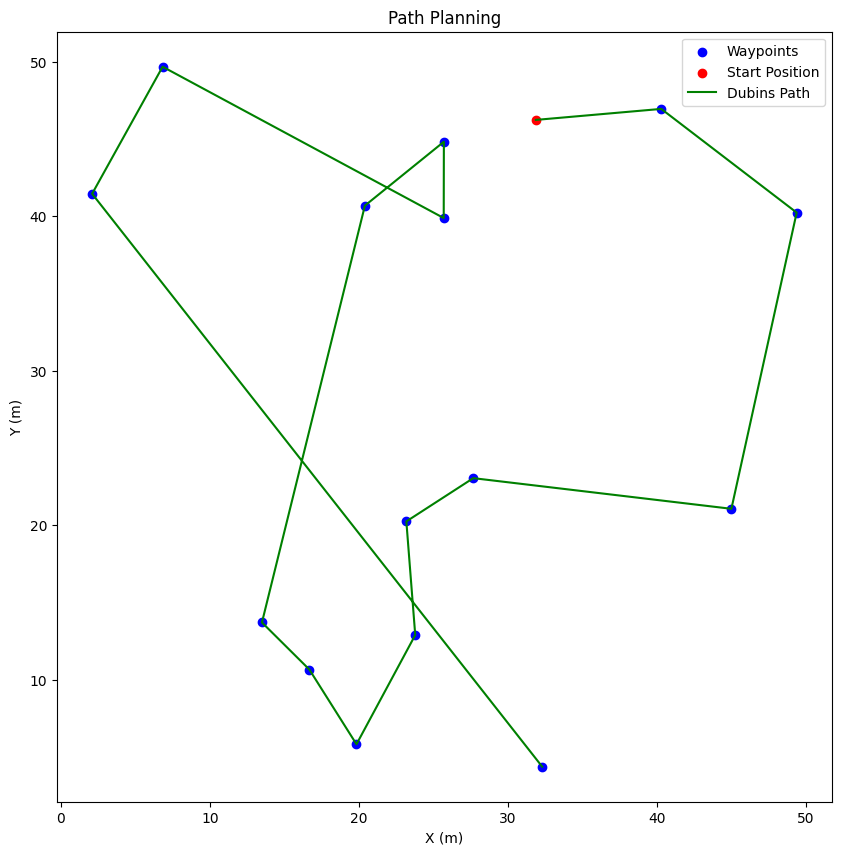

path  [[31.87342514 46.23996494]
 [31.87342514 46.23996494]
 [31.97338347 46.24246442]
 ...
 [32.10811861  4.58409401]
 [32.17339361  4.50833667]
 [32.23866861  4.43257933]]


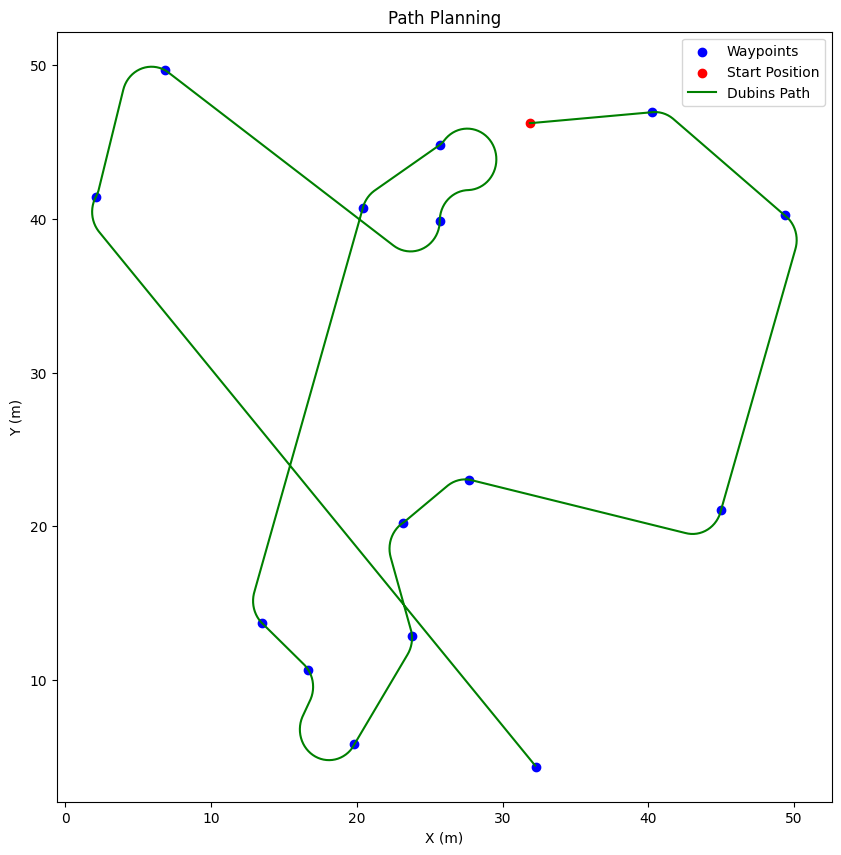

Path Length: 223.20 meters
Path Time: 223.20 seconds


In [169]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial import KDTree
from scipy.spatial import distance
# from dubins import path_sample
from dubins import shortest_path

class PathPlanner:
    def __init__(self, area_size=500, num_points=500, cluster_percentage=0.5
                 , cluster_std=3, min_turning_radius=2):
        self.area_size = area_size
        self.num_points = num_points
        self.cluster_percentage = cluster_percentage
        self.cluster_std = cluster_std
        self.min_turning_radius = min_turning_radius
        self.robot_start_pos = None
        self.waypoints = None
        self.path_length = None
        self.path_time = None
        self.k_nearest_neighbors = 100

    def generate_random_points(self):
        self.waypoints = np.random.uniform(0, self.area_size, (self.num_points, 2))

    def add_clusters(self):
        num_clusters = int(self.num_points * self.cluster_percentage)
        cluster_indices = np.random.choice(range(self.num_points), num_clusters, replace=False)

        for idx in cluster_indices:
            num_plants = np.random.randint(2, 5)
            cluster_center = self.waypoints[idx]
            plants_x = np.random.normal(cluster_center[0], self.cluster_std, num_plants)
            plants_y = np.random.normal(cluster_center[1], self.cluster_std, num_plants)
            cluster_points = np.column_stack((plants_x, plants_y))
        
            self.waypoints = np.concatenate((self.waypoints, cluster_points))
        
    def assign_start_position(self):
        self.robot_start_pos = np.random.uniform(0, self.area_size, 2)
  
    def dubins_path_length(self, start, end, turning_radius):
        '''Calculate the length of the Dubins path between two points'''
        
        samples = self.calculate_dubins_path(start, end)
        path_length = 0
        # print("samples ", samples)
        if len(samples)>2:
            for i in range(len(samples) - 2):
     
                path_length += np.linalg.norm(samples[i + 1] - samples[i])
            # length = sum(distance.euclidean(samples[i][:2], samples[i+1][:2]) for i in range(len(samples)-1))
            print("path_length ", path_length)
            # return np.linalg.norm(end[:2] - start[:2])
            return path_length
        
        return float('inf')  # Return a large number if path is infeasible
    def calculate_angle(self,current_waypoint, next_waypoint):
    # Calculate the direction to the waypoint
        direction_to_waypoint = math.atan2(next_waypoint[1] - current_waypoint[1],next_waypoint[0]
                                           - current_waypoint[0])
        current_angle = 0 # Assuming the robot is facing in the positive x-direction
        # Calculate the angle between the robot's heading and the direction to the waypoint
        angle = math.degrees(direction_to_waypoint - current_waypoint[2])

        # Normalize the angle to the range [-180, 180]
        angle = (angle + 180) % 360 - 180

        return angle
    
    def is_reachable(self, current_waypoint, next_waypoint):
        # Calculate the distance to the waypoint
        distance = math.sqrt((next_waypoint[1]- current_waypoint[1])**2 + (next_waypoint[0] - current_waypoint[0])**2)

        angle = self.calculate_angle(current_waypoint, next_waypoint)

        print("dis",angle ,  current_waypoint , next_waypoint , distance)
 
        # Check if the angle is within the robot's steering limits
        # if angle > 45 or angle < -45:
        #     if distance > 2*self.min_turning_radius  :
        #         return True
        #     else:
        #         return False
        
        if distance > 2*self.min_turning_radius :
            return True

        return False
  
    def dubins_path_planning(self):
        current_pos = self.robot_start_pos
        current_pos = [current_pos[0], current_pos[1], 0]
        waypoints = self.waypoints.copy()
        path = [current_pos]

        while len(waypoints) > 0:
            
            tree = KDTree(waypoints)
            print("waypoints ", waypoints)
            _, indices = tree.query(current_pos[0:2], k=min(self.k_nearest_neighbors, len(waypoints)))
            
            indices = np.array(indices).reshape(-1)
            nearest_waypoints = waypoints[indices]
            delete_index = []
            print("inde" , indices ,nearest_waypoints)
            # reset the nearest_waypoints to only include
            nearest_waypoints = np.array([[]]).reshape(-1, 2)
             # indices with in min_turning_radius
            for index in indices:
                print("index ", index)
                if self.is_reachable(current_pos , waypoints[index]):
                 
                    nearest_waypoints = np.append(nearest_waypoints, [waypoints[index]], axis=0)
                else:
                    delete_index = [index]
            waypoints = np.delete(waypoints, delete_index, axis=0) 

            print("deleted ", delete_index)
            print("waypoints after", waypoints)
            print("nearest_waypoints ", nearest_waypoints)
            nearest_waypoints = nearest_waypoints.reshape(-1, 2)


            distances = [self.dubins_path_length(current_pos , point,self.min_turning_radius) 
                         for point in nearest_waypoints]
            print("distances ", distances)  
            if( len(distances) == 0):
                return np.array(path)
            nearest_idx = np.argmin(distances)
            next_point  = nearest_waypoints[nearest_idx]
            print("next_point ",nearest_idx , next_point)
           
            
            is_reachable = self.is_reachable(current_pos, next_point)
            print("is_reachable ", is_reachable ,distances[nearest_idx])
            
            if is_reachable:

                angle = math.atan2( next_point[1] - current_pos[1], next_point[0] - current_pos[0])
                next_point = [next_point[0], next_point[1], angle]
                path.append(next_point)
                current_pos = next_point
                index = np.where(waypoints == next_point[:2])[0][0]
                waypoints = np.delete(waypoints, index, axis=0)

            else:
                # If the nearest waypoint is not reachable, remove it from the waypoints
                waypoints = np.delete(waypoints, nearest_idx, axis=0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
                pass
         
        return np.array(path).reshape(-1, 3)

    def calculate_dubins_path(self, start, end):
        
        angle =  direction_to_waypoint = math.atan2(end[1] - start[1],end[0]
                                           - start[0])
        
        if len(end) <3:
            end = [end[0], end[1], angle]
        print("start ", start , end)
        configurations = (start[0], start[1], start[2]), (end[0], end[1], end[2])
        path = shortest_path(configurations[0], configurations[1],self.min_turning_radius)
        samples = path.sample_many(0.1)
        # print("sample " , samples)
        return np.array(samples[0])

    def plot_path(self,path):
        path = np.array(path)
        print("path ", path )
        plt.figure(figsize=(10, 10))
        plt.scatter(self.waypoints[:, 0], self.waypoints[:, 1], color='blue', label='Waypoints')
        plt.scatter(self.robot_start_pos[0], self.robot_start_pos[1], color='red', label='Start Position')
        plt.plot(path[:, 0], path[:, 1], color='green', label='Dubins Path')
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('Path Planning')
        plt.legend()
        # plt.grid(True)
        plt.show()

    def calculate_path_length(self, path):
        self.path_length = 0
        
        for i in range(len(path) - 2):
            # print("path[i] ", path[i] , path[i+1])
            self.path_length += np.linalg.norm(path[i + 1] - path[i])
        # self.path_length = np.sum(np.linalg.norm(np.diff(path, axis=0), axis=1))
        self.path_time = self.path_length / 1  # Assuming constant velocity of 1 m/s

    def execute(self):
        self.generate_random_points()
        self.add_clusters()
        self.assign_start_position()
        # self.robot_start_pos = np.array([0, 0])
        # self.waypoints= np.array([[1,0.01]])
        path = self.dubins_path_planning()
        print("Path: ", path)
        waypoints = np.concatenate(([self.robot_start_pos], self.waypoints))
        
        # print("Waypoints: ", waypoints)
        dubins_path = []
        for i in range(len(path) - 1):
            dubins_path.extend(self.calculate_dubins_path(path[i], path[i + 1]))
        dubins_path = np.array(dubins_path)[:,:2]
    
        dubins_path = np.concatenate(([self.robot_start_pos], dubins_path))
        self.plot_path(path)
        self.plot_path(dubins_path)
        self.calculate_path_length(dubins_path)
        print(f"Path Length: {self.path_length:.2f} meters")
        print(f"Path Time: {self.path_time:.2f} seconds")

if __name__ == "__main__":
    path_planner = PathPlanner()
    path_planner.execute()
